In [92]:
import astropy.io.fits as pf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import os
import multiprocessing
import subprocess
import glob
import re
%matplotlib inline

### Directorios del proyecto

In [78]:
DIR_PROYECTO  = '/home/matias/tesis/'
DIR_MOSAICOS  = DIR_PROYECTO + 'fits_face/'
DIR_CATÁLOGOS = DIR_PROYECTO + 'catalogues/'
DIR_SEGMENTACIONES = DIR_PROYECTO + 'segmentation/'
DIR_MORFOLOGÍAS    = DIR_PROYECTO + 'morfologías/'
DIR_DATOS_EAGLE    = DIR_PROYECTO + 'tablas/'
DIR_LOTZ = DIR_PROYECTO + 'gm20/'

### Definición de valores de filtro

In [3]:
U = 121671348.887
G = 168273491.446
R = 178848396.083
I = 69397708.7252
Z = 59157262.0017
U_PRI = 126207773.267
G_PRI = 149732062.76
R_PRI = 188318397.068
I_PRI = 67579475.1401
Z_PRI = 50496673.9991

### Generación del mapa de pesos

In [54]:
hdu = pf.PrimaryHDU(np.ones((256, 256)))
hdu.writeto(DIR_PROYECTO + 'wht1.fits', overwrite=True)

### Generación de archivos para correr el programa de Lotz en modo 'batch'
`zeropt.dat` tiene las magnitudes de base de los mosaicos y `run_gmorph.pro` los mosaicos a procesar. Se generan en el mismo bucle para que el orden de las magnitudes se corresponda con el de los mosaicos.

Borramos los lotes existentes...

In [27]:
for file in glob.glob('*.pro'):
    os.remove(file)

Debido a un error del programa de Lotz que hace que el IDL arroje la excepción "program code area full" en vez de generar un único lote con todos los mosaicos a procesar, generamos varios lotes de hasta 100 mosaicos cada uno. 

In [11]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [28]:
N = 100 # chunk size

for index, chunk in enumerate(chunks(os.listdir(DIR_MOSAICOS), N)):
    
    with open('zeropt.dat', 'w') as zeropt, open('run_gmorph_%02d.pro' % index, 'w') as run_gmorph:
    
        for basename_mosaico in chunk:

            #with pf.open(DIR_MOSAICOS + basename_mosaico) as fits_mosaico:
            #    flujo_total_filtro    = np.sum(fits_mosaico[0].data) / R # flujo total / valor de filtro
            #    magnitud_total_filtro = -2.5 * np.log10(flujo_total_filtro / (3.631e6 * 4.8532896**2))

            #    zeropt.write(str(magnitud_total_filtro) + '\n')

            nombre = os.path.splitext(basename_mosaico)[0] # separa el nombre del archivo de su extensión

            comando = "get_gmorph_new, 0, '%s', '%s', '%s', '%s', '%s'" % ( \
                # catálogo
                DIR_CATÁLOGOS      + nombre + '.cat',      \
                # mosaico
                DIR_MOSAICOS       + nombre + '.fits',     \
                # mapa de pesos
                DIR_PROYECTO       + 'wht1' + '.fits',     \
                # mapa de segmentación
                DIR_SEGMENTACIONES + nombre + '.seg.fits', \
                # archivo de salida
                DIR_MORFOLOGÍAS    + nombre + '.morph'     \
            )

            # Cada línea luce como: get_gmorph_new, 0, 'xxx.cat', 'xxx.fits', 'wht1.fits', 'xxx.fits', 'xxx.morph'
            # "where 0 is the line number in xxx.cat of the starting object"
            run_gmorph.write(comando + '\n')

        run_gmorph.write('exit')

Borramos las morfologías existentes...

In [29]:
for file in glob.glob(DIR_MORFOLOGÍAS + '*.morph'):
    os.remove(file)

Procesamos los lotes con IDL; lo hacemos en paralelo para aprovechar todos los núcleos de la computadora.

In [32]:
def idl(x):
    subprocess.run(['idl', x])
    
with multiprocessing.Pool() as p:
    p.map(idl, glob.glob('*.pro'))

Unimos todos los archivos creados por el programa de Lotz en uno solo. Hay una galaxia por archivo. Además extraemos la ID de la galaxia del nombre del archivo —ya que el programa de Lotz no se fija en esto— y la incluimos dentro del archivo que estamos generando para después tenerlas a mano.

In [62]:
with open('compendio.morph', 'w') as compendio:
    for file in glob.glob(DIR_MORFOLOGÍAS + '*.morph'):
        id = re.search('\d+', file).group(0)
        
        with open(file, 'r') as morfología:    
            for line in morfología:
                if line[0] != '#': # si no es un comentario...
                    compendio.write(id + line)

### Carga de la consulta a la base de datos de EAGLE

In [79]:
encabezado = [
  'id',
  'sfr',
  'm_dm',
  'm_gs',
  'm_st',
  'r_hm',
  'u_mag',
  'g_mag',
  'r_mag'
]

columnas = [0,1,2,3,4,5,10,11,12]

eagle_data = pd.read_csv(DIR_DATOS_EAGLE + 'eagle_db_fits_27.dat', names=encabezado, usecols=columnas)

eagle_data['color_gr'] = eagle_data.g_mag - eagle_data.r_mag

# Magnitudes del SDSS a U-B: U-B = 0.78 * (u - g) - 0.88
eagle_data['color_ub'] = 0.78 * (eagle_data.u_mag - eagle_data.r_mag) - 0.88

### Carga de las morfologías (salida del programa de Lotz)
Do not trust morphologies when `FLAG=1` and/or `<S/N> < 2.5`  and/or `R_ell < 2 x PSF FWHM` (see Lotz et al. astro-ph/0509106).

In [74]:
encabezado = [
  'id',
  's_n',
  'r_ell', # elliptic petrosian radius
  'gini',
  'm20',
  'flag'
]

columnas = [0,6,10,20,21,22]

lotz_data = pd.read_csv('compendio.morph', names=encabezado, usecols=columnas, sep='\s+')

lotz_data = lotz_data[(lotz_data.flag == 0) & (lotz_data.s_n >= 2.5)]

### Join EAGLE con Lotz

In [88]:
df = pd.merge(eagle_data, lotz_data, how='inner', on='id')

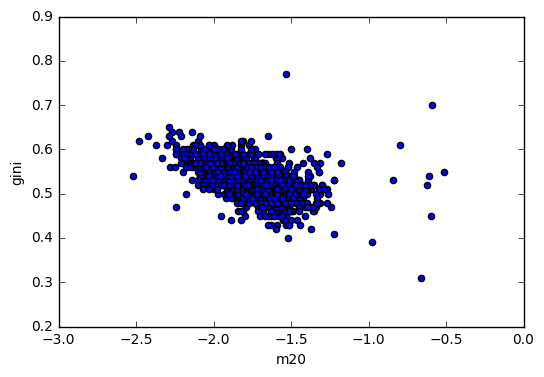

In [93]:
df.plot.scatter(x='m20', y='gini')